In [1]:
total_steel = 14 * 55.5
max_preshower_steel_per_layer = total_steel / 7
max_preshower_steel_per_layer

111.0

In [1]:
import os, sys, subprocess, time, uproot, math, numpy as np, awkward as ak, xml.etree.ElementTree as ET
from sklearn.metrics import roc_auc_score
%env AIDE_HOME=/hpc/group/vossenlab/rck32/eic/dRICH-MOBO/MOBO-tools
%env EPIC_MOBO_UTILS=/hpc/group/vossenlab/rck32/eic/dRICH-MOBO/MOBO-tools/ProjectUtils/ePICUtils/
%env DETECTOR_PATH=/hpc/group/vossenlab/rck32/eic/dRICH-MOBO/MOBO-tools/epic_klm/install/share/epic
%env DETECTOR_CONFIG=epic
%env EIC_SHELL_HOME=/hpc/group/vossenlab/rck32/eic

env: AIDE_HOME=/hpc/group/vossenlab/rck32/eic/dRICH-MOBO/MOBO-tools
env: EPIC_MOBO_UTILS=/hpc/group/vossenlab/rck32/eic/dRICH-MOBO/MOBO-tools/ProjectUtils/ePICUtils/
env: DETECTOR_PATH=/hpc/group/vossenlab/rck32/eic/dRICH-MOBO/MOBO-tools/epic_klm/install/share/epic
env: DETECTOR_CONFIG=epic
env: EIC_SHELL_HOME=/hpc/group/vossenlab/rck32/eic


In [2]:
import matplotlib.pyplot as plot

In [3]:
up_file = uproot.open(os.environ['AIDE_HOME'] + "/log/sim_files/scan_0_mu-_p_1.edm4hep.root")

(array([  1.,   0.,  15.,  86., 118., 129.,  73.,  45.,  17.,  11.]),
 array([2460.98891253, 2520.26194908, 2579.53498564, 2638.80802219,
        2698.08105874, 2757.35409529, 2816.62713184, 2875.9001684 ,
        2935.17320495, 2994.4462415 , 3053.71927805]),
 <BarContainer object of 10 artists>)

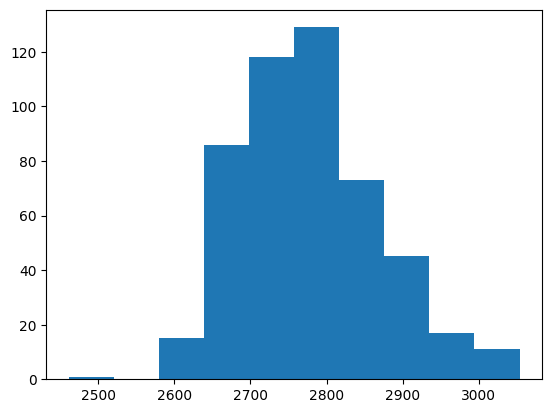

In [4]:
x_hits = up_file['events/HcalBarrelHits/HcalBarrelHits.position.x'].array()
y_hits = up_file['events/HcalBarrelHits/HcalBarrelHits.position.y'].array()
rs = []
for event_idx in range(len(x_hits)):
    event_rs = []
    for hit_idx in range(len(x_hits[event_idx])):
        r = np.sqrt(x_hits[event_idx][hit_idx] ** 2 + y_hits[event_idx][hit_idx]** 2)
        event_rs.append(r)
    if(len(event_rs) > 0):
        rs.append(np.max(np.array(event_rs)))
plot.hist(rs)

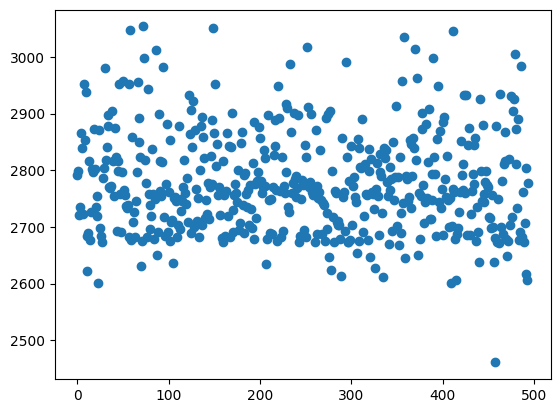

In [5]:
plot.scatter(range(len(rs)),rs)

In [24]:
mu_layers_traveled, mu_layer_counts = np.ones(500,dtype = np.int64) * 13, np.concatenate((np.zeros(13,dtype = np.int64),np.array([500],dtype = np.int64)))
pi_layers_traveled, pi_layer_counts = np.concatenate((np.ones(300,dtype = np.int64) * 10,np.ones(100,dtype = np.int64) * 11,np.ones(50,dtype = np.int64) * 12,np.ones(50,dtype = np.int64) * 13)),np.concatenate((np.zeros(10),np.array([300,100,50,50])))

In [26]:
layers_traveled_tot = np.concatenate((mu_layers_traveled, pi_layers_traveled),dtype = np.int64)

In [33]:
# 1 if particle is muon, 0 if particle is pion
pid_actual = np.concatenate((np.ones_like(mu_layers_traveled), np.zeros_like(pi_layers_traveled)))

In [37]:
# probability that a particle stopping at this layer is a muon
pid_layer_prob = np.divide(mu_layer_counts, mu_layer_counts + pi_layer_counts, out=np.zeros(mu_layer_counts.size), where=(mu_layer_counts+pi_layer_counts)!=0)

In [41]:
# probability that each particle is a muon
# This is the prediction of the probability given the layer reached for that event
pid_model = pid_layer_prob[layers_traveled_tot]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.90909091])

In [29]:
# calculate ROC AUC score
roc_score = roc_auc_score(pid_actual, pid_model)

In [93]:
def pl(item):
    print(item)
    print(len(item))
    return

In [139]:
class Manager():
    def __init__(self, p_points, n_part, job_id):
        self.p_points = p_points
        self.n_part = n_part
        self.job_id = job_id
        self.outname = str(os.environ["AIDE_HOME"])+"/log/results/"+ "klm-mobo-out_{}.txt".format(job_id)
        self.slurm_job_ids = []
        self.calcGeomVals()
        
    def checkOverlap(self):
        shellcommand = [str(os.environ["EPIC_MOBO_UTILS"])+"/overlap_wrapper_job.sh",str(self.job_id)]

        commandout = subprocess.run(shellcommand,stdout=subprocess.PIPE)
        output = commandout.stdout.decode('utf-8')
        
        lines = output.split('\n')
        last_line = lines[-2] if lines else None
        if last_line:
            line_split = last_line.split()
            if len(line_split) == 1:
                return int(line_split[0])
            else:
                return -1
        else:
            return -1
        return -1    
    
    def makeSlurmScript(self):       
        filename = str(os.environ["AIDE_HOME"])+"/slurm_scripts/"+"jobconfig_{}.slurm".format(self.job_id)
        with open(filename,"w") as file:
            file.write("#!/bin/bash\n")
            file.write(f"#SBATCH --job-name=submit-workflow-klm-mobo-{self.job_id}\n")
            file.write("#SBATCH --account=vossenlab\n")
            file.write("#SBATCH --partition=common\n")
            file.write("#SBATCH --mem=2G\n")
            file.write("#SBATCH --time=8:00:00\n")
            file.write("#SBATCH --output={}/klm-mobo-subjob_%j.out\n".format(str(os.environ["AIDE_HOME"])+"/log/job_output"))
            file.write("#SBATCH --error={}/klm-mobo-subjob_%j.err\n".format(str(os.environ["AIDE_HOME"])+"/log/job_output"))
            DETECTOR_PATH = os.environ['DETECTOR_PATH']
            DETECTOR_CONFIG = os.environ['DETECTOR_CONFIG']
            compactFileName = f"{DETECTOR_PATH}/{DETECTOR_CONFIG}_{self.job_id}.xml"
            MOBO_path = "/hpc/home/rck32/groupdir/eic/dRICH-MOBO/MOBO-tools/"
            loadEpicPath = os.environ['AIDE_HOME'] + "/load_epic.sh"
            setupPath = os.environ['AIDE_HOME'] + "/setup.sh"
            file.write(f"python3 /hpc/group/vossenlab/rck32/eic/work_eic/slurm/submit_workflow.py --compactFile {compactFileName} --setupPath {setupPath} --loadEpicPath {loadEpicPath} --run_name_pref April_2_mobo_{self.job_id} --outFile {self.outname} --runNum {self.job_id} --chPath {MOBO_path} --deleteDfs True --no-saveGif")
        return filename
    def makeSlurmScript_mupi(self, p_point):
        p = p_point           
        filename = str(os.environ["AIDE_HOME"])+"/slurm_scripts/"+"jobconfig_{}_p_{}.slurm".format(self.job_id,p)
        with open(filename,"w") as file:
            file.write("#!/bin/bash\n")
            file.write("#SBATCH --job-name=mu_pi-klm-mobo\n")
            file.write("#SBATCH --account=vossenlab\n")
            file.write("#SBATCH --partition=common\n")
            file.write("#SBATCH --mem=2G\n")
            file.write("#SBATCH --time=8:00:00\n")
            file.write("#SBATCH --output={}/klm-mobo-subjob_mu_pi_%j.out\n".format(str(os.environ["AIDE_HOME"])+"/log/job_output"))
            file.write("#SBATCH --error={}/klm-mobo-subjob_mu_pi_%j.err\n".format(str(os.environ["AIDE_HOME"])+"/log/job_output"))
            
            file.write(str(os.environ["EPIC_MOBO_UTILS"])+"shell_wrapper_job.sh {} {} {} {} {} \n".format(p,self.n_part,self.theta_min,self.theta_max,self.job_id))
        return filename
    
    def runJobs(self):
        #mu pi separation jobs
        for p_point in self.p_points:
            slurm_file = self.makeSlurmScript_mupi(p_point)                
            shellcommand = ["sbatch",slurm_file]                
            commandout = subprocess.run(shellcommand,stdout=subprocess.PIPE)
            output = commandout.stdout.decode('utf-8')
            line_split = output.split()
            if len(line_split) == 4:
                slurm_job_id = int(line_split[3])
                self.slurm_job_ids.append(slurm_job_id)
            else:
                #slurm job submission failed, re-submit? or just count as failed?
                self.slurm_job_ids.append(-1)
        # neutral hadron energy resolution jobs
        '''
        slurm_file = self.makeSlurmScript()                
        shellcommand = ["sbatch",slurm_file]                
        commandout = subprocess.run(shellcommand,stdout=subprocess.PIPE)
        output = commandout.stdout.decode('utf-8')
        line_split = output.split()
        if len(line_split) == 4:
            slurm_job_id = int(line_split[3])
            self.slurm_job_ids.append(slurm_job_id)
        else:
            #slurm job submission failed, re-submit? or just count as failed?
            self.slurm_job_ids.append(-1)
        '''
        return
    
    def get_job_status(self, slurm_id):
        # check status of slurm job        
        if slurm_id == -1:
            # something failed in job submission
            return -1
        ### HERE: run bash command to retrieve status, exit code                                                         
        shellcommand = [str(os.environ["AIDE_HOME"])+"/ProjectUtils/"+"checkSlurmStatus.sh", str(slurm_id)]
        commandout = subprocess.run(shellcommand,stdout=subprocess.PIPE)
        
        output = commandout.stdout.decode('utf-8')        
        line_split = output.split()

        if len(line_split) == 1:
            status = line_split[0]
        else:
            #something wrong, try again                                                                                  
            print("Error in checking slurm status, assuming still running")
            return 0

        #  0 - running
        #  1 - completed
        # -1 - failed
        if status == "0":
            return 0
        elif status == "1":
            return 1
        elif status == "-1":
            return -1
        return 0

    def monitorJobs(self):
        # loop to check every minute if all sub-jobs are finished 
        complete = False
        while not complete:
            statuses = []
            allDone = True
            for slurm_id in self.slurm_job_ids:
                status = self.get_job_status(slurm_id)
                statuses.append(status)
                if status == 0:
                    allDone = False
            if allDone == True:
                print("Jobs finished, final statuses: ", statuses)
                complete = True
                self.final_job_status = statuses
            else:
                time.sleep(30)
        return
    
    def writeFailedObjectives(self):
        raise Exception("Writing failed objectives error")
    
    def retrieveResults(self):
        # when results finished, retrieve analysis script outputs
        # and calculate objectives

        if self.final_job_status[i] == 1:
            with open(self.outname) as f:
                low_RMSE = float(f.readline().strip())
                high_RMSE = float(f.readline().strip())
            if((low_RMSE < 0) or (high_RMSE < 0)):
                manager.writeFailedObjectives()
            else:
                print(f"Results successfully aquired\n low RMSE: {low_RMSE}; high RMSE: {high_RMSE}")
        else:
            sys.exit(1)
        return

    def retrieveResults_mupi(self):
        # when results finished, retrieve analysis script outputs
        # and calculate objectives
        roc_scores = []
        for i, p_point in enumerate(self.p_points):
            if self.final_job_status[i] == 1:
                roc_score = self.calcROCauc(
                    mu_f = os.path.join(os.environ['AIDE_HOME'], f'log/sim_files/scan_{self.job_id}_mu-_p_{p_point}.edm4hep.root'),
                    pi_f = os.path.join(os.environ['AIDE_HOME'], f'log/sim_files/scan_{self.job_id}_pi-_p_{p_point}.edm4hep.root')
                )
                roc_scores.append(roc_score)
        
        if len(roc_scores) == len(self.p_points):
            final_results = np.array(roc_scores)
        else:
            # if all jobs failed for a momentum point, exit failed
            # TODO: is this how we want to treat this case?
            sys.exit(1)
        with open(self.outname, "a") as f:
#             f.write(f"\n{final_results[0]}")
            for result in final_results:
                f.write(f"\n{result}")
#             print(f"Writing roc scores: {final_results}")
        return
    def calcGeomVals(self):
        # lengths in mm
        # superlayer geom:
        # steel layer | air gap 1 | scintillating layer 1 | air gap 2 | air gap 3 | scintillating layer 2 | air gap 4
        
        xmlfile = f'/hpc/group/vossenlab/rck32/eic/dRICH-MOBO/MOBO-tools/epic_klm/compact/pid/klmws.xml'
        root = ET.parse(xmlfile).getroot()

        self.superlayer_count = int(root.find(".//constant[@name='HcalScintillatorNbLayers']").get('value')) # number of superlayers
        self.steel_thick = float(root.find(".//constant[@name='HcalSteelThickness']").get('value')[:-3]) # thickness of steel sublayer
        self.sens_sublayer_thick = float(root.find(".//constant[@name='HcalScintillatorThickness']").get('value')[:-3]) # thickness of sensitive sublayer
        
        self.inner_radius = 1770 # starting radial position of first layer
        self.air_gap_thick = 0.3 # thickness of air gap between sublayers
        self.superlayer_dist = self.steel_thick + self.sens_sublayer_thick + self.air_gap_thick * 2 # width of superlayer
        
        self.outer_radius = self.inner_radius + self.superlayer_count * self.superlayer_dist # outer radius of barrel
        
        self.sector_count = 8 # number of radial sectors
        self.barrel_length = 1500 # length of the barrel along the z-axis
        self.barrel_offset = 18 # offset of the barrel in the positive z direction
        
        # min/max theta angles to shoot particle gun
        self.theta_min = 90 + np.rad2deg(np.arctan( (-self.barrel_length / 2 + self.barrel_offset) / self.outer_radius )) * 0.85
        self.theta_max = 90 + np.rad2deg(np.arctan( (self.barrel_length / 2 + self.barrel_offset) / self.outer_radius )) * 0.85

        self.first_sens_sublayer_pos = self.inner_radius + self.steel_thick + self.air_gap_thick  # position of first sensitive sublayer

        # array containing the start pos of each sensitive sublayer
        self.layer_pos = np.zeros(self.superlayer_count * 2) # 2 sensitive sublayers per superlayer
        self.layer_pos = [self.first_sens_sublayer_pos + self.superlayer_dist*i for i in range(self.superlayer_count)] # first sublayers 

    # returns the distance in the direction of the nearest sector
    def sector_proj_dist(self, xpos, ypos):
        sector_angle = (np.arctan2(ypos, xpos) + np.pi / self.sector_count) // (2*np.pi / self.sector_count) * 2*np.pi / self.sector_count # polar angle (in radians) of the closest sector
        return xpos * np.cos(sector_angle) + ypos * np.sin(sector_angle) # scalar projection of position vector onto unit direction vector 

    # returns the layer number for the position of a detector hit
    def layer_num(self, xpos, ypos):
        pos = self.sector_proj_dist(xpos, ypos)
        # false if hit position is before the first sensitive sublayer or after the last sensitive sublayer 
        within_layer_region = np.logical_and(pos * 1.0001 > self.layer_pos[0], pos / 1.0001 < self.layer_pos[-1] + self.sens_sublayer_thick)
        superlayer_index = np.where(within_layer_region, ak.values_astype( (pos * 1.0001 - self.layer_pos[0]) // self.superlayer_dist, 'int64'), -1) # index of superlayer the hit may be in, returns -1 if out of region
        layer_pos_dup = ak.Array(np.broadcast_to(self.layer_pos, (int(ak.num(superlayer_index, axis=0)), len(self.layer_pos)))) # turn layer_pos into a 2d array with duplicate rows to allow indexing
        dis_from_first_sublayer = np.where(within_layer_region, pos - layer_pos_dup[superlayer_index], -1) # distance of hit from the first sublayer in the superlayer, returns -1 if out of region
        # true if hit is within the first of the paired layers
        in_first_layer = np.logical_and(within_layer_region, dis_from_first_sublayer / 1.0001 <= self.sens_sublayer_thick)

        # layer number of detector hit; returns -1 if not in a layer
        hit_layer = np.where(in_first_layer, superlayer_index + 1, -1)
        return hit_layer

    # returns the number of pixels detected by a hit
    def pixel_num(self, energy_dep, zpos):
        inverse = lambda x : 4.9498 / (29.9733 - x + self.barrel_length / 2) - 0.0016796
        efficiency = inverse(zpos - self.barrel_offset) + inverse(self.barrel_offset - zpos) # ratio of photons produced in a hit that make it to the sensor
        return 10 * energy_dep * (1000 * 1000) * efficiency * 0.5

    # takes in position and energy deposited for a hit as ragged 2d awkward arrays
    # with each row corresponding to hits produced by a particle and its secondaries
    # returns 1d numpy array containing number of layers traveled by each track (-1: hits not in any layer, -2: hits produce too few pixels, -3: no hits for this particle)
    # and a 1d numpy array containing number of terminating tracks for each layer, starting at layer 1 
    def layer_calc(self, xpos, ypos, zpos, energy_dep):
        hit_layer = self.layer_num(xpos, ypos)
        hit_layer_filtered = np.where(self.pixel_num(energy_dep, zpos) >= 2, hit_layer, -2) # only accept layers with at least 2 pixels
        # Nones might appear if an event had 0 hits
        layers_traveled = ak.fill_none(ak.max(hit_layer_filtered, axis=1), -3) # max accepted layers traveled for a track determines total layers traveled
        layer_counts = np.asarray(ak.sum(layers_traveled[:, None] == np.arange(1, self.superlayer_count + 1), axis=0)) # find counts for each layer, 1 through max
        return np.asarray(layers_traveled)[layers_traveled >= 1], layer_counts

    # return the area under the ROC curve for discriminating between muons and pions
    def calcROCauc(self, mu_f, pi_f):
        with uproot.open(mu_f) as mu_file:
            mu_hit_x = mu_file['events/HcalBarrelHits.position.x'].array()
            mu_hit_y = mu_file['events/HcalBarrelHits.position.y'].array()
            mu_hit_z = mu_file['events/HcalBarrelHits.position.z'].array()
            mu_hit_edep = mu_file['events/HcalBarrelHits.EDep'].array()

        with uproot.open(pi_f) as pi_file:
            pi_hit_x = pi_file['events/HcalBarrelHits.position.x'].array()
            pi_hit_y = pi_file['events/HcalBarrelHits.position.y'].array()
            pi_hit_z = pi_file['events/HcalBarrelHits.position.z'].array()
            pi_hit_edep = pi_file['events/HcalBarrelHits.EDep'].array()

        mu_layers_traveled, mu_layer_counts = self.layer_calc(mu_hit_x, mu_hit_y, mu_hit_z, mu_hit_edep)
        pl(mu_layers_traveled)
        pl(mu_layer_counts)
        pi_layers_traveled, pi_layer_counts = self.layer_calc(pi_hit_x, pi_hit_y, pi_hit_z, pi_hit_edep)
        layers_traveled_tot = np.concatenate((mu_layers_traveled, pi_layers_traveled))
        # 1 if particle is muon, 0 if particle is pion
        pid_actual = np.concatenate((np.ones_like(mu_layers_traveled), np.zeros_like(pi_layers_traveled)))
        # probability that a particle stopping at this layer is a muon
        pid_layer_prob = np.divide(mu_layer_counts, mu_layer_counts + pi_layer_counts, out=np.zeros(mu_layer_counts.size), where=(mu_layer_counts+pi_layer_counts)!=0)
        # probability that each particle is a muon
        pid_model = pid_layer_prob[layers_traveled_tot - 1]

        # calculate ROC AUC score
        roc_score = roc_auc_score(pid_actual, pid_model)

        return roc_score

In [140]:
manager = Manager(p_points, n_part, job_id)
manager.final_job_status = [1]

In [141]:
manager.retrieveResults_mupi()

[12 13 13 12 13 11 14 12 13 14 12 12 12 11 12 13 12 13 12 12 12 13 13 12
 12 12 13 11 14 12 12 12 14 12 12 13 13 11 13 11 12 12 14 12 13 11 13 12
 13 12 13 14 12 12 11 11 12 11 12 12 13 12 13 13 13 12 12 14 13 13 13 13
 13 10 10 13 12 13 13 12 12 13 12 13 14 12 12 12 14 13 11 12 14 12 14 12
 14 11 13 13 13 14 13 14 12 11 14 14 13 12 13 13 11 12 12 12 14 12 13  8
 10 12 12 13 12 13 12 13 12 12 14 14 12 11 14 14 11 12 12 12 12 13 12 12
 13 12 14 14 12 11 12 13 13 14 13 12 11 11 14 13 13 13 13 13 12 14 12 13
 13 14 13 13 11 13 11 11 12 11 13 13 12 12 13 14 11 12 13 12 12 12 12 13
 11 13 12  9 11  2 13 12 13 12 13 12 12 12 12 12 11 14 13 11 12 12 12 13
 11 12 14 13 12 11 14 14 12 11 12 13 13 12 12 13 13 12 12 11 12 11 11 11
 14 13 12 13 11 11 12 12 13 13 10 12 13 13 13 12 13 14 13 13 11 12 11 12
 14 12 13 11 11 13 14 14 13  8 13 12 13 12 12 12 13 12 12 13 11 12 12 13
 13 14 12 11 12 12 13 13 11 13 13 12 13 12 12 12 13 12 13 11 12 11 11 14
 12 12 14 13 11 13 13 10 12 12 12 11 11 11 14 12 13

In [63]:
# p_points = [str(int(1))]
# n_part = 500
# job_id = 0
# manager = Manager(p_points, n_part, job_id)
# # noverlaps = manager.checkOverlap()
# manager.runJobs()
# manager.monitorJobs()

Error in checking slurm status, assuming still running
Jobs finished, final statuses:  [1]


In [ ]:
from collections import defaultdict
class Manager():
    def __init__(self, p_points, n_part, job_id):
        self.p_points = p_points
        self.n_part = n_part
        self.job_id = job_id
        self.outname = str(os.environ["AIDE_HOME"])+"/log/results/"+ "klm-mobo-out_{}.txt".format(job_id)
        self.slurm_job_ids = []
        self.load_geometry(f"{DETECTOR_PATH}/{DETECTOR_CONFIG}_{self.job_id}.xml")
        
    def checkOverlap(self):
        shellcommand = [str(os.environ["EPIC_MOBO_UTILS"])+"/overlap_wrapper_job.sh",str(self.job_id)]

        commandout = subprocess.run(shellcommand,stdout=subprocess.PIPE)
        output = commandout.stdout.decode('utf-8')
        
        lines = output.split('\n')
        last_line = lines[-2] if lines else None
        if last_line:
            line_split = last_line.split()
            if len(line_split) == 1:
                return int(line_split[0])
            else:
                return -1
        else:
            return -1
        return -1    
    
    def makeSlurmScript(self):       
        filename = str(os.environ["AIDE_HOME"])+"/slurm_scripts/"+"jobconfig_{}.slurm".format(self.job_id)
        with open(filename,"w") as file:
            file.write("#!/bin/bash\n")
            file.write(f"#SBATCH --job-name=submit-workflow-klm-mobo-{self.job_id}\n")
            file.write("#SBATCH --account=vossenlab\n")
            file.write("#SBATCH --partition=common\n")
            file.write("#SBATCH --mem=2G\n")
            file.write("#SBATCH --time=8:00:00\n")
            file.write("#SBATCH --output={}/klm-mobo-subjob_%j.out\n".format(str(os.environ["AIDE_HOME"])+"/log/job_output"))
            file.write("#SBATCH --error={}/klm-mobo-subjob_%j.err\n".format(str(os.environ["AIDE_HOME"])+"/log/job_output"))
            DETECTOR_PATH = os.environ['DETECTOR_PATH']
            DETECTOR_CONFIG = os.environ['DETECTOR_CONFIG']
            compactFileName = f"{DETECTOR_PATH}/{DETECTOR_CONFIG}_{self.job_id}.xml"
            MOBO_path = "/hpc/home/rck32/groupdir/eic/dRICH-MOBO/MOBO-tools/"
            loadEpicPath = os.environ['AIDE_HOME'] + "/load_epic.sh"
            setupPath = os.environ['AIDE_HOME'] + "/setup.sh"
            file.write(f"python3 /hpc/group/vossenlab/rck32/eic/work_eic/slurm/submit_workflow.py --compactFile {compactFileName} --setupPath {setupPath} --loadEpicPath {loadEpicPath} --run_name_pref April_2_mobo_{self.job_id} --outFile {self.outname} --runNum {self.job_id} --chPath {MOBO_path} --deleteDfs True --no-saveGif")
        return filename
    def makeSlurmScript_mupi(self, p_point):
        p = p_point           
        filename = str(os.environ["AIDE_HOME"])+"/slurm_scripts/"+"jobconfig_{}_p_{}.slurm".format(self.job_id,p)
        with open(filename,"w") as file:
            file.write("#!/bin/bash\n")
            file.write("#SBATCH --job-name=mu_pi-klm-mobo\n")
            file.write("#SBATCH --account=vossenlab\n")
            file.write("#SBATCH --partition=common\n")
            file.write("#SBATCH --mem=2G\n")
            file.write("#SBATCH --time=8:00:00\n")
            file.write("#SBATCH --output={}/klm-mobo-subjob_mu_pi_%j.out\n".format(str(os.environ["AIDE_HOME"])+"/log/job_output"))
            file.write("#SBATCH --error={}/klm-mobo-subjob_mu_pi_%j.err\n".format(str(os.environ["AIDE_HOME"])+"/log/job_output"))
            
            file.write(str(os.environ["EPIC_MOBO_UTILS"])+"shell_wrapper_job.sh {} {} {} {} {} \n".format(p,self.n_part,self.theta_min,self.theta_max,self.job_id))
        return filename
    
    def runJobs(self):
        #mu pi separation jobs
        for p_point in self.p_points:
            slurm_file = self.makeSlurmScript_mupi(p_point)                
            shellcommand = ["sbatch",slurm_file]                
            commandout = subprocess.run(shellcommand,stdout=subprocess.PIPE)
            output = commandout.stdout.decode('utf-8')
            line_split = output.split()
            if len(line_split) == 4:
                slurm_job_id = int(line_split[3])
                self.slurm_job_ids.append(slurm_job_id)
            else:
                #slurm job submission failed, re-submit? or just count as failed?
                self.slurm_job_ids.append(-1)
        # neutral hadron energy resolution jobs
        '''
        slurm_file = self.makeSlurmScript()                
        shellcommand = ["sbatch",slurm_file]                
        commandout = subprocess.run(shellcommand,stdout=subprocess.PIPE)
        output = commandout.stdout.decode('utf-8')
        line_split = output.split()
        if len(line_split) == 4:
            slurm_job_id = int(line_split[3])
            self.slurm_job_ids.append(slurm_job_id)
        else:
            #slurm job submission failed, re-submit? or just count as failed?
            self.slurm_job_ids.append(-1)
        '''
        return
    
    def get_job_status(self, slurm_id):
        # check status of slurm job        
        if slurm_id == -1:
            # something failed in job submission
            return -1
        ### HERE: run bash command to retrieve status, exit code                                                         
        shellcommand = [str(os.environ["AIDE_HOME"])+"/ProjectUtils/"+"checkSlurmStatus.sh", str(slurm_id)]
        commandout = subprocess.run(shellcommand,stdout=subprocess.PIPE)
        
        output = commandout.stdout.decode('utf-8')        
        line_split = output.split()

        if len(line_split) == 1:
            status = line_split[0]
        else:
            #something wrong, try again                                                                                  
            print("Error in checking slurm status, assuming still running")
            return 0

        #  0 - running
        #  1 - completed
        # -1 - failed
        if status == "0":
            return 0
        elif status == "1":
            return 1
        elif status == "-1":
            return -1
        return 0

    def monitorJobs(self):
        # loop to check every minute if all sub-jobs are finished 
        complete = False
        while not complete:
            statuses = []
            allDone = True
            for slurm_id in self.slurm_job_ids:
                status = self.get_job_status(slurm_id)
                statuses.append(status)
                if status == 0:
                    allDone = False
            if allDone == True:
                print("Jobs finished, final statuses: ", statuses)
                complete = True
                self.final_job_status = statuses
            else:
                time.sleep(30)
        return
    
    def writeFailedObjectives(self):
        raise Exception("Writing failed objectives error")
    
    def retrieveResults(self):
        # when results finished, retrieve analysis script outputs
        # and calculate objectives

        if self.final_job_status[i] == 1:
            with open(self.outname) as f:
                low_RMSE = float(f.readline().strip())
                high_RMSE = float(f.readline().strip())
            if((low_RMSE < 0) or (high_RMSE < 0)):
                manager.writeFailedObjectives()
            else:
                print(f"Results successfully aquired\n low RMSE: {low_RMSE}; high RMSE: {high_RMSE}")
        else:
            sys.exit(1)
        return

    def retrieveResults_mupi(self):
        # when results finished, retrieve analysis script outputs
        # and calculate objectives
        roc_scores = []
        for i, p_point in enumerate(self.p_points):
            if self.final_job_status[i] == 1:
                roc_score = self.calcROCauc(
                    mu_f = os.path.join(os.environ['AIDE_HOME'], f'log/sim_files/scan_{self.job_id}_mu-_p_{p_point}.edm4hep.root'),
                    pi_f = os.path.join(os.environ['AIDE_HOME'], f'log/sim_files/scan_{self.job_id}_pi-_p_{p_point}.edm4hep.root')
                )
                roc_scores.append(roc_score)
        
        if len(roc_scores) == len(self.p_points):
            final_results = np.array(roc_scores)
        else:
            # if all jobs failed for a momentum point, exit failed
            # TODO: is this how we want to treat this case?
            sys.exit(1)
        with open(self.outname, "a") as f:
#             f.write(f"\n{final_results[0]}")
            for result in final_results:
                f.write(f"\n{result}")
#             print(f"Writing roc scores: {final_results}")
        return

    def load_geometry(self,compactFile):
        lcdd = dd4hep.Detector.getInstance()
        lcdd.fromXML(compactFile)
        print(f"loaded compact file: {compactFile}")
        self.lcdd = lcdd
        
        root = ET.parse(compactFile).getroot()
        self.n_layers = int(root.find(".//constant[@name='HcalScintillatorNbLayers']").get('value')) # number of superlayers

    # hit is object from looping over root_file
    def get_layer_number(self, hit):
        cellID = hit.cellID
    #     print(f"CellID: {cellID}")

        # Get the IDDescriptor for the HcalBarrel
        id_spec = self.lcdd.idSpecification("HcalBarrelHits")
        if not id_spec:
            print("Failed to get IDSpecification for HcalBarrelHits")
            return None

        id_dec = id_spec.decoder()

        # Extract individual field values
        try:
            layer = id_dec.get(cellID, "layer")
        except Exception as e:
            print(f"Error decoding cellID: {e}")
            return None

        return layer

    # returns the number of pixels detected by a hit
    def pixel_num(self, energy_dep, zpos):
        inverse = lambda x : 4.9498 / (29.9733 - x + self.barrel_length / 2) - 0.0016796
        efficiency = inverse(zpos - self.barrel_offset) + inverse(self.barrel_offset - zpos) # ratio of photons produced in a hit that make it to the sensor
        return 10 * energy_dep * (1000 * 1000) * efficiency * 0.5

    def layer_calc_cellID(self,root_file_path):
        root_file = ROOT.TFile(root_file_path)
        tree = root_file.Get("events")
        z_positions = [] #debugging to make sure this is zpos not x or y
        
        num_pixels_per_layer = np.zeros((len(tree),self.n_layers))
        for event_idx, event in enumerate(tree):
            for hit_idx, hit in enumerate(event.HcalBarrelHits):
                layer_num = get_layer_number(hit)
                zpos = hit.position[2]
                z_positions.append(zpos)
                eDep = hit.eDep
                num_pixels = pixel_num(eDep,zpos)
                if(layer_num >=0 and layer_num <self.n_layers):
                    num_pixels_per_layer[event_idx,layer_num] += num_pixels
                else:
                    print(f"Found hit #{hit_idx} in event #{event_idx} to be in layer #{layer_num}, which does not fit compact file definition. Skipping hit...")
        #get mask for valid hit layers
        mask = num_pixels_per_layer >= 2

        layers_traveled = np.empty(num_pixels_per_layer.shape[0], dtype=int)
        layer_counts = np.zeros(self.n_layers)
        
        # For each event, get furthest layer hit
        for i, row_mask in enumerate(mask):
            indices = np.where(row_mask)[0]
            #get last index
            layers_traveled[i] = indices[-1] if indices.size > 0 else -1
            layer_counts[layers_traveled[i]] += 1
        return layers_traveled, layer_counts
                
    # return the area under the ROC curve for discriminating between muons and pions
    def calcROCauc(self, mu_f, pi_f)
        mu_layers_traveled, mu_layer_counts = self.layer_calc_cellID(mu_f)
        pi_layers_traveled, pi_layer_counts = self.layer_calc_cellID(pi_f)
        layers_traveled_tot = np.concatenate((mu_layers_traveled, pi_layers_traveled))
        # 1 if particle is muon, 0 if particle is pion
        pid_actual = np.concatenate((np.ones_like(mu_layers_traveled), np.zeros_like(pi_layers_traveled)))
        # probability that a particle stopping at this layer is a muon
        pid_layer_prob = np.divide(mu_layer_counts, mu_layer_counts + pi_layer_counts, out=np.zeros(mu_layer_counts.size), where=(mu_layer_counts+pi_layer_counts)!=0)
        # probability that each particle is a muon
        pid_model = pid_layer_prob[layers_traveled_tot - 1]

        # calculate ROC AUC score
        roc_score = roc_auc_score(pid_actual, pid_model)

        return roc_score